In [1]:
# Copyright (c) 2015, Cordoba Astronomical Observatory.  All rights reserved.
#                    Unauthorized reproduction prohibited. 
# NAME:
#        aligo-vs-glade
# PURPOSE:
#        "Toritos Scheduler White catalog loader
#
# CATEGORY:
#	     Program.
#
# COMPILING SEQUENCE:
# 	     ipython notebook
#
# INPUTS:
#
#
# MODIFICATION HISTORY:
# 	Written by:	Mariano Dominguez, July 2015
#   from previuos version using White Catalog January 2014.
#   Any inquirities send an e-mail to mardom@oac.uncor.edu
#

# Modified by Bruno Sanchez, October 2015

In [203]:
# Global paths and constants
data_path = '.'
# Load useful packages
import os
import numpy as np
import math as m

import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u

#import seaborn
%matplotlib inline

In [18]:
#graphic output directory.
plots = './plots'
if not os.path.isdir(plots):
    os.mkdir(plots)

In [155]:
import time
print (time.strftime("%d/%m/%Y"))
print (time.strftime("%H:%M:%S"))

macon_date=time.strftime("%Y/%m/%d %H:%M:%S")

print 

10/11/2015
03:47:24



In [156]:
import ephem
macon = ephem.Observer()
macon.lat = '-24.623'
macon.lon = '-67.328'
macon.elevation = 4600

In [213]:
# extracting the correct values. WEIRD
float(ephem.degrees(macon.lon*180./m.pi)), float(ephem.degrees(macon.lat*180./m.pi))

(-67.328, -24.623)

In [236]:
sun = ephem.Sun()
sun.compute(macon)
print sun.a_ra, sun.a_dec
sun_coords = SkyCoord(str(sun.a_ra), str(sun.a_dec), unit=(u.hourangle, u.deg))

print "Sun coordinates are = {}".format(sun_coords.to_string('hmsdms'))

moon = ephem.Moon()
moon.compute(macon)
moon_coords = SkyCoord(str(moon.a_ra), str(moon.a_dec), unit=(u.hourangle, u.deg))

print "Moon coordinates are = {}".format(moon_coords.to_string('hmsdms'))

14:59:27.80 -17:00:15.7
Sun coordinates are = 14h59m27.8s -17d00m15.7s
Moon coordinates are = 13h59m48.48s -09d22m27.6s


In [237]:
sunrise, sunset = sun.rise_time, sun.set_time

print "The time of sunset is {}, \nand the time of sunrise is {}".format(sunset, sunrise)

The time of sunset is 2015/11/10 22:48:34, 
and the time of sunrise is 2015/11/10 09:38:11


In [238]:
# at sunset 
alpha_zenith_sunset = sun_coords.ra + 90.*u.deg
alpha_observable_min = alpha_zenith_sunset - 40.*u.deg

In [239]:
# at sunrise
alpha_zenith_sunrise = sun_coords.ra - 90.*u.deg
alpha_observable_max = alpha_zenith_sunset + 40.*u.deg

In [240]:
print alpha_observable_min.hour, alpha_observable_max.hour

18.3243888889 23.6577222222


In [241]:
white_cat='./GWGCCatalog.txt'

white_table = ascii.read(white_cat, delimiter=' ', format='commented_header')#, data_start=2

#white_table

In [242]:
dist_lim = 80.
near = white_table['Dist'] < dist_lim      # Distance cut
visible = white_table['App_Mag']< 18.5     # Apparent Magnitude cut
bright = white_table['Abs_Mag']< -18.      # Absolute Magnitude cut
lim_dec = white_table['Dec']< 30.          # Declination cut
alfa_min = white_table['RA'] >  float(alpha_observable_min.hour)       # Alpha cut 
alfa_max = white_table['RA'] <= float(alpha_observable_max.hour)

/home/bruno/.virtualenvs/alertreport/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/bruno/.virtualenvs/alertreport/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


In [243]:
if alpha_observable_max.hour > alpha_observable_min.hour:
    sample = white_table[near & visible & bright & lim_dec & (alfa_min & alfa_max)]
else:
    sample = white_table[near & visible & bright & lim_dec & (alfa_min | alfa_max)]

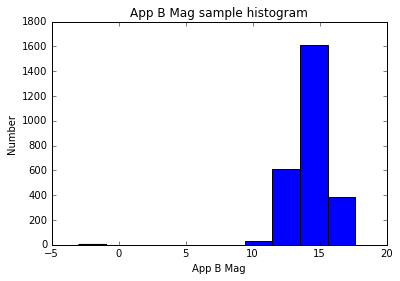

In [244]:
plt.hist(sample['App_Mag'])
plt.xlabel('App B Mag')
plt.ylabel('Number')
plt.title('App B Mag sample histogram')

plt.savefig(os.path.join(plots, 'appmag_sample_histogram.png'), dpi=300)

plt.show()

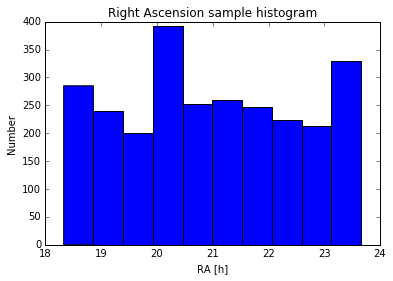

In [245]:
plt.hist(sample['RA'])
plt.xlabel('RA [h]')
plt.ylabel('Number')
plt.title('Right Ascension sample histogram')

plt.savefig(os.path.join(plots, 'RA_sample_histogram.png'), dpi=300)

plt.show()

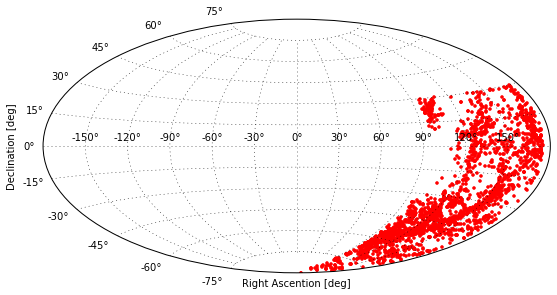

In [246]:
plt.figure(figsize=(10,10))
plt.subplot(211, projection="aitoff")
deg2rad=np.pi/180.

xg = (sample['RA']*15. - 180)*deg2rad
yg = sample['Dec']*deg2rad

# we should avoid the galactic plane
plt.plot(xg,yg, "r.")
plt.grid(True)
plt.xlabel("Right Ascention [deg]")
plt.ylabel("Declination [deg]")
plt.savefig(os.path.join(plots, 'radec_aitoff_sample.png'), dpi=300)
plt.show()

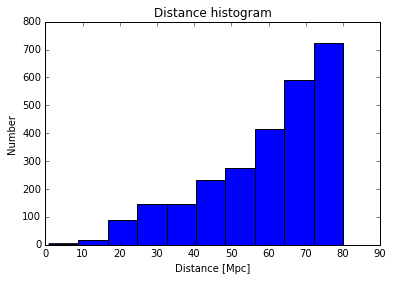

In [247]:
plt.hist(sample['Dist'], range=[1,dist_lim])
plt.title('Distance histogram')

plt.xlabel('Distance [Mpc]')
plt.ylabel('Number')



plt.show()

In [248]:
import healpy as hp

In [170]:
aligo_alert_data_file=os.path.join(data_path,"skymap.fits")
NSIDE=512 #2048
aligo_banana = hp.read_map(aligo_alert_data_file)

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


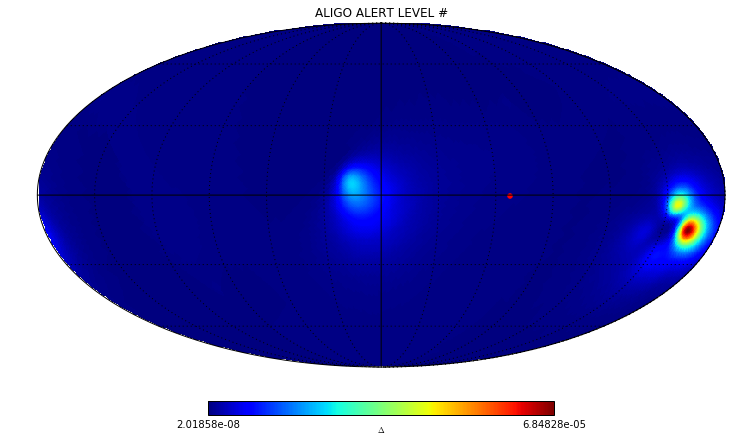

In [206]:
# plot the banana map
fig = plt.figure(2, figsize=(10, 10))
hp.mollview(aligo_banana, title='ALIGO ALERT LEVEL #', flip="astro",
            unit='$\Delta$', fig=2)
fig.axes[1].texts[0].set_fontsize(8)
hp.projscatter(ephem.degrees(macon.lon*180./m.pi), float(ephem.degrees(macon.lat)), lonlat=True, color="red")

hp.graticule()

plt.savefig(os.path.join(plots, 'allsky_likelihoodmap.png'), dpi=300)

plt.show()

86.4865542549 93.5134457451 -3.51344574512 3.51344574512
The interval between parallels is 1 deg 0.00'.
The interval between meridians is 1 deg 0.00'.


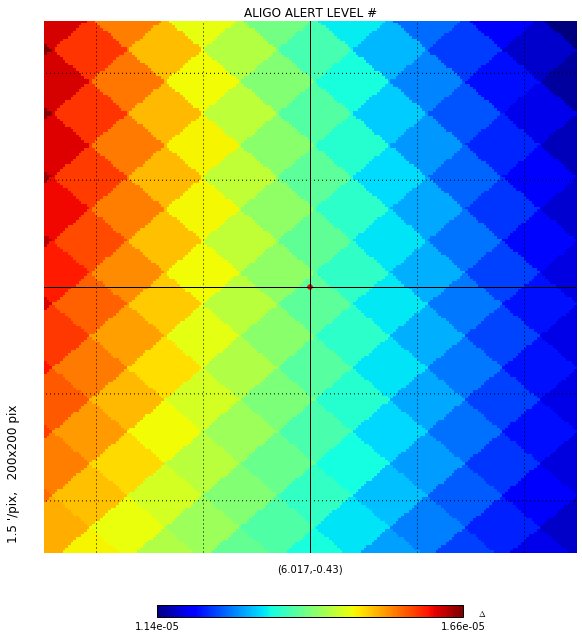

In [189]:
# plot the banana map
fig = plt.figure(2, figsize=(10, 10))
rot=[(alpha_observable_max.hour+alpha_observable_min.hour)/2., macon.lat]
hp.gnomview(aligo_banana, rot=rot, title='ALIGO ALERT LEVEL #', flip="astro",
            unit='$\Delta$', fig=2)
fig.axes[1].texts[0].set_fontsize(8)
hp.projscatter(rot, lonlat=True, color="red")

hp.graticule()

plt.savefig(os.path.join(plots, 'allsky_likelihoodmap.png'), dpi=300)

plt.show()

84.7292948675 95.2707051325 -5.27070513245 5.27070513245
The interval between parallels is 1 deg 0.00'.
The interval between meridians is 1 deg 0.00'.


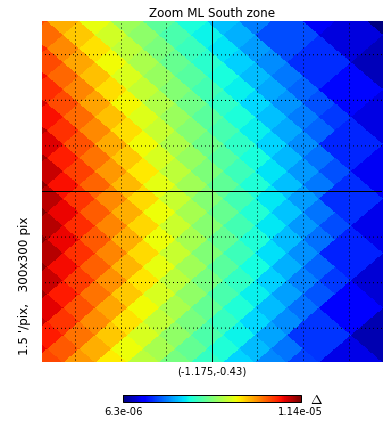

In [177]:
hp.gnomview(aligo_banana,rot=[macon.lon,macon.lat], xsize=300, ysize=300, title="Zoom ML South zone", 
            unit="$\Delta$", fig=2)
hp.graticule()

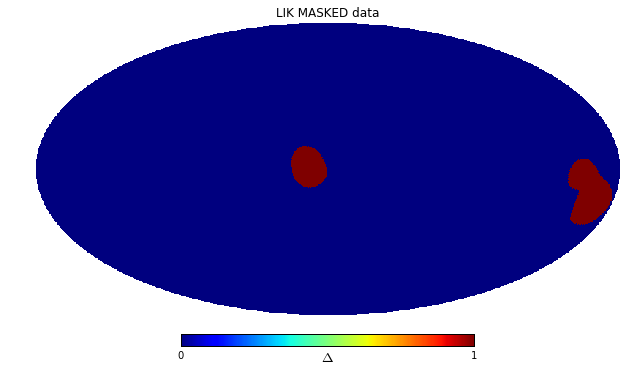

In [25]:
likehood_cut=0.00001 # cut level for mask buildup
aligo_alert_map_high_like=np.logical_not(aligo_banana < likehood_cut)
hp.mollview(aligo_alert_map_high_like, title='LIK MASKED data',
            unit='$\Delta$', fig=2)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


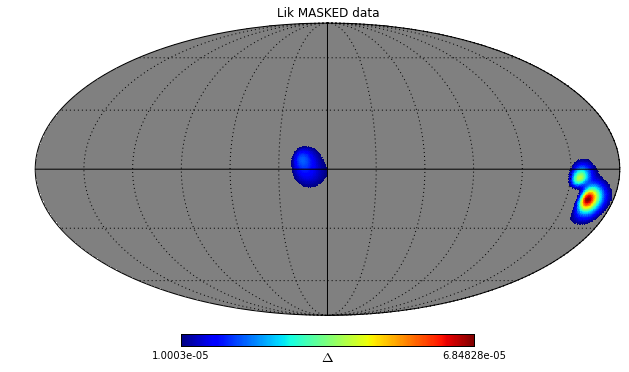

In [26]:
# masked Likelihood map 
map_lik_masked=hp.ma(aligo_banana)
map_lik_masked.mask=np.logical_not(aligo_alert_map_high_like)
hp.mollview(map_lik_masked.filled(), title='Lik MASKED data',
            unit='$\Delta$', fig=2)
hp.graticule()

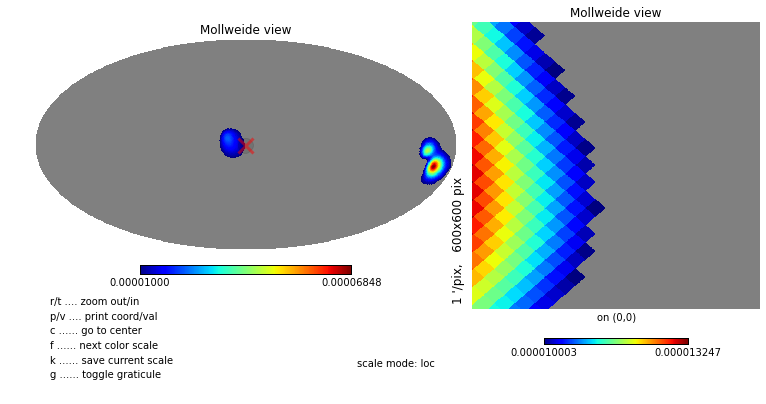

In [30]:
max_lik_coord = None
candidate_coord = (221.69, -3.246)
hp.mollzoom(map_lik_masked.filled())#,candidate_coord)

In [31]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import math
indy=0
deg2rad=math.pi/180.
indx = len(sample)
targetRA = np.zeros(indx)
targetDec = np.zeros(indx)
targetLik= np.zeros(indx)
targetMag=np.zeros(indx)
target_a = np.zeros(indx)
target_b = np.zeros(indx)
name2 = []
#totgal=0. tolerance if galactic cut is impossed due to confussion, measure it!
for row in sample:
    filename=row['PGC']
    #savefig("../plots/"+filename+".eps")
    rat=row['RA']*15.
    dect=row['Dec']
    #ipix = hp.ang2pix(NSIDE,theta,phi)  # be carefull its using mathematical coordinates hereafter
    theta= math.pi/2.-dect*deg2rad
    # colatitude in radians measured southward from north pole (in [0,$\pi$]). 
    phi= rat*deg2rad
    if phi <  0.: phi=phi+2.*pi 
    # longitude in radians measured eastward (in [0, $2\pi$])  
    if hp.pixelfunc.get_interp_val(aligo_alert_map_high_like,theta,phi,nest=False)  > 0.2:
        #the value of 0.2 is due to the averaging process on npix=4!     
        targetMag[indy]=row['App_Mag']
        targetRA[indy]=row['RA']
        targetDec[indy]= row['Dec']
        target_a[indy]=row['Maj_Diam_a']
        target_b[indy]=row['Min_Diam_b']
        name2.append(row['Name'])
        targetLik[indy]= hp.pixelfunc.get_interp_val(aligo_banana,theta,phi,nest=False) # alternatively use masked Lik
        indy=indy+1 
    #hp.gnomview(aligo_alert_map_high_like,rot=[n.galactic.b.deg,n.galactic.l.deg], xsize=15, ysize=15, title=filename, unit='$\Delta$', fig=2)
    #hp.graticule()
    #plt.show()

420


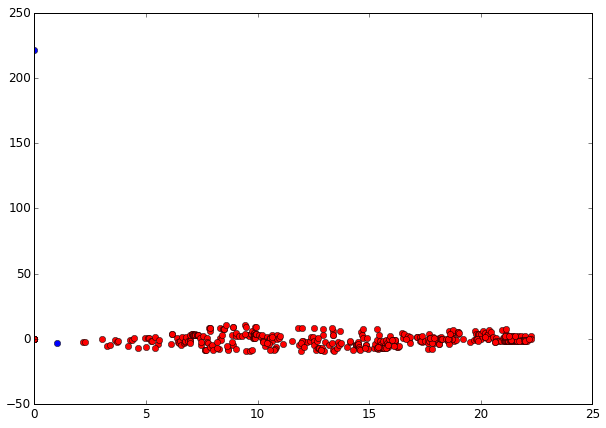

In [43]:
print indy
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.rcParams.update({"font.size":12})
plt.plot(targetRA*15.,targetDec, "ro")
plt.plot(candidate_coord, 'bo')#, radius=5, alpha=1., color='b')
plt.show()

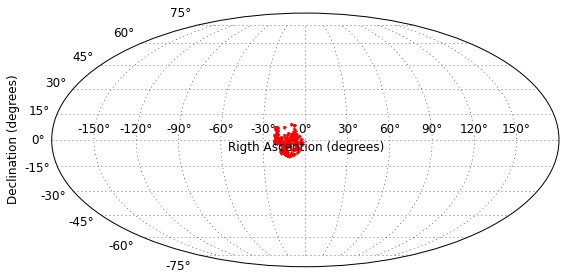

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(211, projection="mollweide")
deg2rad=math.pi/180.
j=0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360,360)
for i in range(indy):
        x = np.remainder(targetRA[i]*15.+360,360) # shift RA values
        if x > 180.: 
            x = x-360. # scale conversion to [-180, 180]
        x=-x    # reverse the scale: East to the left
        xg[j]=x*deg2rad 
        yg[j]=(targetDec[i])*deg2rad
        #print gx[j], xg[j], yg[j]
        j=j+1
        ,       
plt.plot(xg[0:j],yg[0:j], "r.")
#axes.set_xticklabels(tick_labels)     # we add the scale on the x axis
plt.grid(True)
plt.xlabel("Rigth Ascention (degrees)")
plt.ylabel("Declination (degrees)")

Uno puede ahora usar las galaxias (visibles) dentro de la mascara y rankearlas como mas le guste.
Se pueden ordenar simplemente por Likehood por ejemplo, ahora dado que van a estar observando varios
telescopios (quizas conviene acordar quien mira quien) y las mejoras de posteriores de las alertas
cambian el negocio substancialmente ademas del input de nuestras mediciones

In [25]:
index_array=np.argsort(targetLik[0:indy])
#print index_array

In [48]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import FK5
print 'N       RAJ2000      DecJ2000      Likelihood    MagB   RAJ2015   DecJ2015    Name'
RAJ2015 = []
DecJ2015 = []
likelihood = []
RAJ2000 = []
DecJ2000= []
AppMag  = []
name3 = []
dist = []
RA = []
Dec = []
for i in range(indy):
    ind=index_array[indy-i-1]
    coord=SkyCoord(ra=targetRA[ind]*u.hourangle, dec=targetDec[ind]*u.degree, frame='icrs')
    precessed=coord.transform_to(FK5(equinox='J2015.7'))
    RAJ2015.append(precessed.to_string('hmsdms').split()[0])
    DecJ2015.append(precessed.to_string('hmsdms').split()[1])
    strcoord = coord.to_string('hmsdms')
    RA.append(strcoord.split()[0])
    Dec.append(strcoord.split()[1])
    RAJ2000.append(targetRA[ind])
    DecJ2000.append(targetDec[ind])
    AppMag.append(targetMag[ind])
    likelihood.append(targetLik[ind])
    name3.append(name2[ind])
    dist.append(Dist[ind])
    #print i, coord.to_string('hmsdms'), targetLik[ind], targetMag[ind], RAJ2015[i], DecJ2015[i], name2[ind]

N       RAJ2000      DecJ2000      Likelihood    MagB   RAJ2015   DecJ2015    Name


In [27]:
from astropy.table import Table
candidates = Table()
candidates.add_column(Table.Column(name3, name=('Name')))
candidates.add_column(Table.Column(RAJ2000, name=('RAJ2000')))
candidates.add_column(Table.Column(DecJ2000, name=('DecJ2000')))
candidates.add_column(Table.Column(likelihood, name=('Likelihood')))
candidates.add_column(Table.Column(AppMag, name=('Appmag')))
candidates.add_column(Table.Column(RA, name=('RA')))
candidates.add_column(Table.Column(Dec, name=('Dec')))
candidates.add_column(Table.Column(RAJ2015, name=('RAJ2015')))
candidates.add_column(Table.Column(DecJ2015, name=('DecJ2015')))
candidates.add_column(Table.Column(dist, name=('Distance')))

In [28]:
candidates.sort(['RAJ2000','Likelihood'])

In [29]:
candidates.write('candidates20151022_textable.csv', format='csv')

In [30]:
southern = candidates['DecJ2000']<0

In [31]:
southern_sources = candidates[southern]

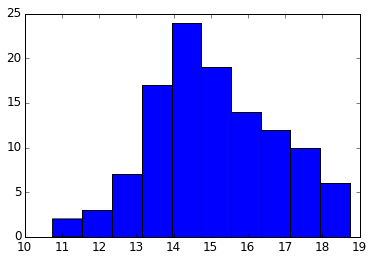

In [49]:
plt.hist(southern_sources['Appmag'])
plt.show()

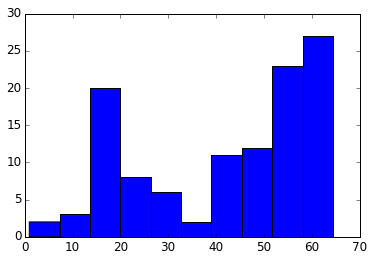

In [50]:
plt.hist(southern_sources['Distance'])
plt.show()

In [34]:
far = southern_sources['Distance']>35.
far_away = southern_sources[far]

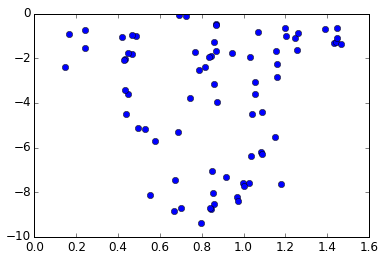

In [51]:
plt.plot(far_away['RAJ2000'], far_away['DecJ2000'], 'bo')
plt.show()

In [36]:
far_away.sort('Likelihood')

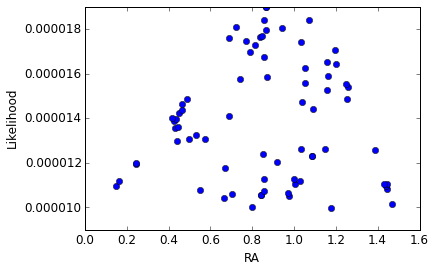

In [37]:
plt.plot(far_away['RAJ2000'], far_away['Likelihood'], 'bo')
plt.xlabel('RA')
plt.ylabel('Likelihood')
for source in far_away:
    plt.Annotation(s=source['Name'], xy=(source['RAJ2000'], source['Likelihood']), xycoords='data')
#plt.Annotation(s='hola', xy=(5,0.001), xycoords='data')
plt.show()

In [38]:
far_away.reverse()

In [39]:
far_away

Name,RAJ2000,DecJ2000,Likelihood,Appmag,RA,Dec,RAJ2015,DecJ2015,Distance
string184,float64,float64,float64,float64,unicode416,unicode448,unicode448,unicode480,float64
PGC003043,0.86656,-0.48669,1.89672942806e-05,14.7,00h51m59.616s,-00d29m12.084s,00h52m47.8569s,-00d24m05.6202s,61.611
SDSSJ005159.73-002921.3,0.86659,-0.48926,1.8967163301e-05,17.05,00h51m59.724s,-00d29m21.336s,00h52m47.9647s,-00d24m14.8727s,54.097
PGC003015,0.85836,-1.25304,1.84088512786e-05,14.8,00h51m30.096s,-01d15m10.944s,00h52m18.2742s,-01d10m04.3276s,45.792
PGC3108496,1.07071,-0.84452,1.83993268927e-05,17.83,01h04m14.556s,-00d50m40.272s,01h05m02.752s,-00d45m38.0564s,49.972
NGC0237,0.72439,-0.12503,1.80941049741e-05,13.28,00h43m27.804s,-00d07m30.108s,00h44m16.076s,-00d02m21.202s,52.5
NGC0307,0.94239,-1.77206,1.80431465284e-05,13.52,00h56m32.604s,-01d46m19.416s,00h57m20.7259s,-01d41m14.4283s,46.819
PGC003040,0.86633,-1.67176,1.79473879058e-05,16.91,00h51m58.788s,-01d40m18.336s,00h52m46.9305s,-01d35m11.8676s,64.431
NGC0271,0.84497,-1.91014,1.7669233315e-05,12.55,00h50m41.892s,-01d54m36.504s,00h51m30.0185s,-01d49m29.6416s,52.819
PGC002920,0.8348,-1.95191,1.76559894769e-05,15.25,00h50m05.28s,-01d57m06.876s,00h50m53.4049s,-01d51m59.8293s,60.806


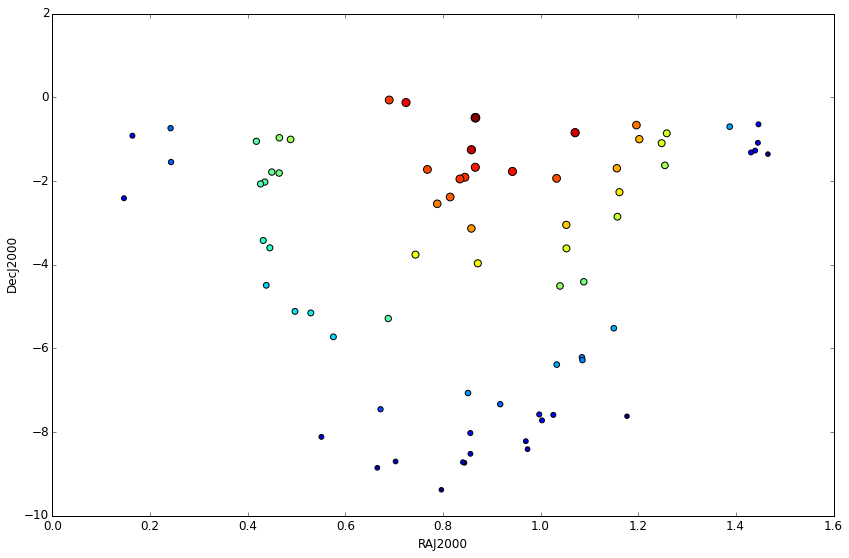

In [40]:

plt.figure(figsize=(14,9))
plt.scatter(np.asarray(far_away['RAJ2000']), np.asarray(far_away['DecJ2000']), s=2E11*far_away['Likelihood']**2., 
            c=far_away['Likelihood'])
plt.xlabel('RAJ2000')
plt.ylabel('DecJ2000')
plt.show()

In [41]:
a_hi = far_away['RAJ2000']<7.
a_lo = far_away['RAJ2000']>0.5
secbin= far_away[a_hi & a_lo]
lik = secbin['Likelihood']

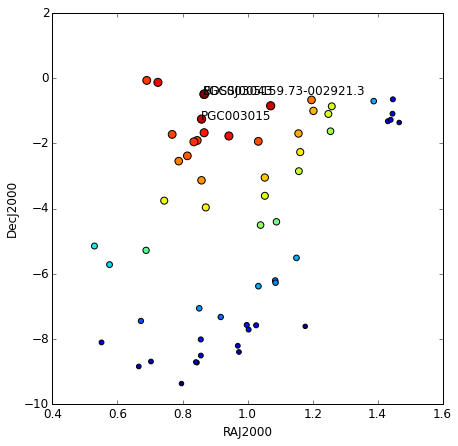

In [42]:
plt.figure(figsize=(7,7))
plt.scatter(np.asarray(secbin['RAJ2000']), np.asarray(secbin['DecJ2000']), s=2E11*secbin['Likelihood']**2., 
            c=secbin['Likelihood'])
for goodies in range(3):
    row = secbin[goodies]
    plt.annotate(s=str(row['Name']), xy=(row['RAJ2000'], row['DecJ2000']))

plt.xlabel('RAJ2000')
plt.ylabel('DecJ2000')
plt.show()

In [43]:
aaa = SkyCoord(ra=secbin[7]['RAJ2000']*u.hourangle, dec=secbin[7]['DecJ2000']*u.degree)
aaa.to_string('hmsdms')

u'00h50m41.892s -01d54m36.504s'

In [44]:
bbb = SkyCoord(ra=secbin[0]['RAJ2000']*u.hourangle, dec=secbin[0]['DecJ2000']*u.degree)
bbb.to_string('hmsdms')

u'00h51m59.616s -00d29m12.084s'

In [45]:
b_hi = candidates['RAJ2000']<7.5
b_lo = candidates['RAJ2000']>5.5
dist_lo = candidates['Distance']>35.
mag_hi = candidates['Appmag']< 17.
thirdbin= candidates[b_hi & b_lo & mag_hi & dist_lo]
thirdbin.sort('Likelihood')

In [46]:
bbb = SkyCoord(ra=thirdbin[1]['RAJ2000']*u.hourangle, dec=thirdbin[1]['DecJ2000']*u.degree)
bbb.to_string('hmsdms')

IndexError: index 1 out of range for table with length 0

In [ ]:
thirdbin

In [ ]:
SkyCoord